In [2]:
import numpy as np
import cv2
import copy
import os, matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F

import albumentations as A # Library for augmentations

import matplotlib.pyplot as plt

from tqdm import tqdm

print(A.__version__)

1.3.1


In [3]:
from MyUtils import transforms, utils, engine, train as transforms, utils, engine, train
from MyUtils.utils import collate_fn
from MyUtils.engine import train_one_epoch, evaluate
from MyUtils.plot_statistic import plot_stats
from MyUtils.visulaize import visualize

In [4]:
def weighted_average(points):
    import numpy as np
    xyz = [[point[0], point[1], point[2]] for point in points]
    weights = [score[3] for score in points]
    average = np.average(xyz, axis=0, weights=weights).tolist()
    weights = np.mean(weights)
    average.append(weights)
    return tuple(average)

def mean_points(points):
    import numpy as np
    return tuple(np.mean(points, axis=0).tolist())

def max_point(points):
    return max(points, key=lambda x: x[3])

points = [(55.0, 40.0, 50.0, 5.0)]
print(points)
#print(points[:, :3])
print(weighted_average(points))
print(mean_points(points))
print(max_point(points))

[(55.0, 40.0, 50.0, 5.0)]
(55.0, 40.0, 50.0, 5.0)
(55.0, 40.0, 50.0, 5.0)
(55.0, 40.0, 50.0, 5.0)


In [5]:
#import shutil

#images = [file[:-4] for file in sorted(os.listdir(os.path.join('./NEW_DATASET', "images")))]
#annotations = [file[:-4] for file in sorted(os.listdir(os.path.join('./NEW_DATASET', "annotations"))) if not file=='classes.txt']

#for annotation in annotations:
#    if not annotation in images:
#        os.remove(os.path.join('./NEW_DATASET', 'annotations', f'{annotation}.txt'))

if not None:
    print('test')

test


In [6]:
#temp_folder = './test_dataset/train/temp/'

#imgs = os.listdir(temp_folder)

#for num, img in enumerate(imgs):
#    os.rename(os.path.join(temp_folder, img), os.path.join(temp_folder, f'dataset_{num + 1}.jpg'))

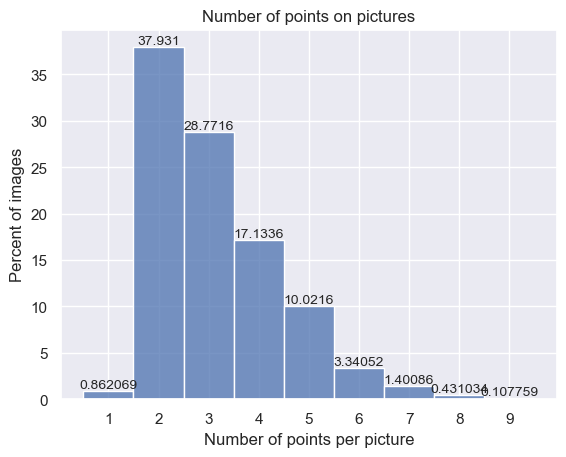

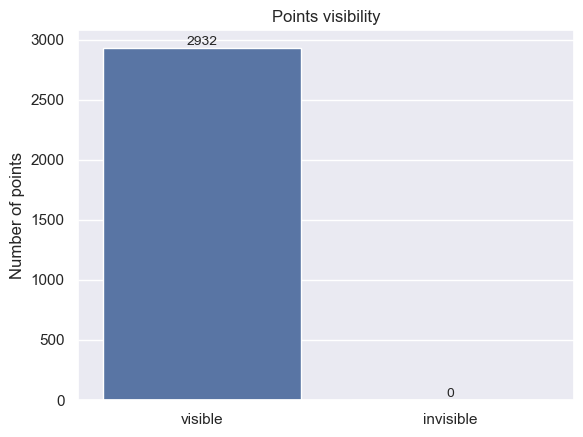

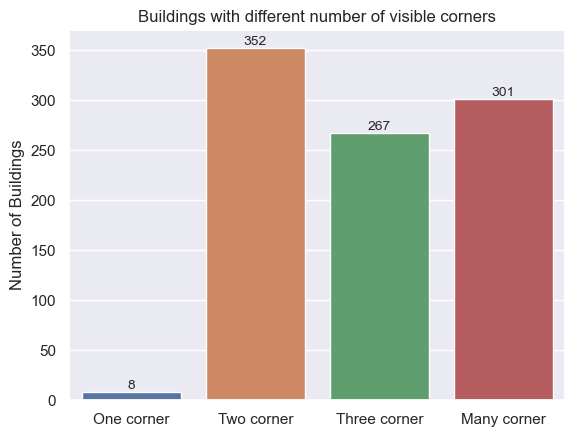

Files without buildings:




In [7]:
path = 'C:/Users/User/Petr/Net_2/NEW_DATASET/9c_dataset/'

annotations_files = [file for file in sorted(os.listdir(os.path.join(path, "annotations")) ) if not file=='classes.txt']

max_lines = 0
nums_of_points = []
point_visibility = {'visible': 0, 'invisible': 0}
buildings = {'One corner': 0, 'Two corner': 0, 'Three corner': 0, 'Many corner': 0}
#two_corner_files = []
#three_corners_files = []
files_without_buildings = []
for file in annotations_files: 
    with open(os.path.join(path, "annotations/") + file, 'r') as f:
        visible_points = 0
        lines = f.readlines()
        sum_p = 0
        building_marked = False
        for line in lines:
            if int(line.split()[0]) in (0, 1):
                sum_p += 1
            if int(line.split()[0]) == 0:
                visible_points += 1
            if int(line.split()[0]) == 2:
                building_marked = True
        if not building_marked:
            files_without_buildings.append(file)
        #if sum_p == 10:
            #print(file)
        nums_of_points.append(sum_p)
        for line in lines:
            if line.startswith('0'):
                point_visibility['visible'] += 1
            elif line.startswith('1'):
                point_visibility['invisible'] += 1
                #print(file)
        if visible_points == 1:
            buildings['One corner'] += 1
            #print(file)
        elif visible_points == 2:
            buildings['Two corner'] += 1
            #two_corner_files.append(file[:-4]) 
        elif visible_points == 3:
            buildings['Three corner'] += 1
            #three_corners_files.append(file[:-4])
        else:
            buildings['Many corner'] += 1
            #print(file)
    
            
import seaborn as sns

sns.set_theme()

NPoints_hist = sns.histplot(nums_of_points, discrete=True, kde=False, stat='percent')
#NPoints_hist.bar_label(NPoints_hist.containers[0], fontsize=10)
NPoints_hist.set_title('Number of points on pictures')
NPoints_hist.set_xlabel('Number of points per picture')
NPoints_hist.set_ylabel('Percent of images')
NPoints_hist.set(xticks=np.arange(1,10,1))
for container in NPoints_hist.containers:
    NPoints_hist.bar_label(container, fontsize=10)

plt.show()

visibility = sns.barplot(x=list(point_visibility.keys()), y=list(point_visibility.values()))
visibility.bar_label(visibility.containers[0], fontsize=10)
visibility.set_title('Points visibility')
visibility.set_ylabel('Number of points')
plt.show()

buildings_corners = sns.barplot(x=list(buildings.keys()), y=list(buildings.values()))
buildings_corners.bar_label(buildings_corners.containers[0], fontsize=10)
buildings_corners.set_title('Buildings with different number of visible corners')
buildings_corners.set_ylabel('Number of Buildings')
plt.show()

print('Files without buildings:\n')
print(*files_without_buildings)

In [8]:
class ClassDataset(Dataset):
    def __init__(self, root, transform=None, demo=False):              
        self.root = root
        self.transform = transform
        self.demo = demo # Use demo=True if you need transformed and original images (for example, for visualization purposes)
        self.imgs_files = sorted(os.listdir(os.path.join(root, "images")))
        self.annotations_files = sorted(os.listdir(os.path.join(root, "annotations")))
        self.annotations_files = [file for file in self.annotations_files if not file=='classes.txt']
        self.N = 9
        #with open(os.path.join(root, "annotations", 'classes.txt'), 'r') as f:
            #self.classes = f.readlines()
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs_files[idx])
        annotations_path = os.path.join(self.root, "annotations", self.annotations_files[idx])

        img_original = cv2.imread(img_path)
        img_h, img_w = img_original.shape[0], img_original.shape[1]
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
        #print(type(img_original))
        
        with open(annotations_path) as f:
            lines = f.readlines()
        
        keypoints_original = [[]]
        for line in lines:
            line = line.strip().split()
            if int(line[0]) in (0, 1):
                x_c, y_c = round(float(line[1]) * img_w), round(float(line[2]) * img_h)
                #x_c, y_c = float(line[1]), float(line[2])
                if int(line[0]) == 0:
                    visibility = 1
                    #keypoints_original[0].append([x_c, y_c, visibility])
                else:
                    visibility = 0
                keypoints_original[0].append([x_c, y_c, visibility])
            elif int(line[0]) == 2:
                x_c, y_c = round(float(line[1]) * img_w), round(float(line[2]) * img_h)
                width, height = round(float(line[3]) * img_w), round(float(line[4]) * img_h)
                #x_c, y_c = float(line[1]), float(line[2])
               # width, height = float(line[3]), float(line[4])
                
                x1, y1, x2, y2 = (2*x_c - width)/2, (2*y_c - height)/2, (2*x_c + width)/2, (2*y_c + height)/2
                
                #print(x1, y1, x2, y2)
                
                #x1, y1, x2, y2 = min([x1, 1.0]), min([y1, 1.0]), min([x2, 1.0]), min([y2, 1.0])
                
                #x1 = (center_X-width/2)*image_width
                #x2 = (center_X+width/2)*image_width
                #y1 = (center_y-height/2)*image_height
                #y2 = (center_y+height/2)*image_height
                bboxes_original = [[x1, y1, x2, y2]]
        kps = copy.deepcopy(keypoints_original)
        #print(kps)
        while len(keypoints_original[0]) < self.N:
            keypoints_original[0].append([0, 0, 0])      
            # All objects are glue tubes
        #print(len(kps[0]))
        for i in range(self.N):
            #print((i + len(kps)) % self.N, '\n', i % len(kps))
            #print(kps[0][i % len(kps[0])])
            keypoints_original[0][i] = kps[0][i % len(kps[0])]
        #print(f'kps:\n{kps}\n\nkeypoints_original:\n{keypoints_original}')
        bboxes_labels_original = ['Building']            
 # [[[x, y, v], [x, y, v], [0 , 0, 0], [0 , 0, 0], [0 , 0, 0], [0 , 0, 0], [0 , 0, 0], [0 , 0, 0], [0 , 0, 0], [0 , 0, 0]]]
        if self.transform:   
            # Converting keypoints from [x,y,visibility]-format to [x, y]-format + Flattening nested list of keypoints            
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]], where each keypoint is in [x, y]-format            
            # Then we need to convert it to the following list:
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2]
            keypoints_original_flattened = [el[0:2] for kp in keypoints_original for el in kp]
            #                              [[x, y] for sublist in lst for item in sublist for x, y,_ in item]
#            print(keypoints_original, '\n', keypoints_original_flattened)
            # Apply augmentations
           # keypoints_original_flattened = (np.array(keypoints_original_flattened) * [img_w, img_h]).astype(np.int32).tolist()
           # bboxes_original_t = (np.array(bboxes_original) * [[img_w, img_h, img_w, img_h]]).astype(np.int32).tolist()
#            print(bboxes_original_t)
            try:
                transformed = self.transform(image=img_original, bboxes=bboxes_original, bboxes_labels=bboxes_labels_original, keypoints=keypoints_original_flattened)
            except Exception as e:
                print(f'Lines was:\n{lines}\n\n\nImage width and height: {img_w}, {img_h}\n\n\nImage path: {img_path}')
                raise e
            img = transformed['image']
            
            h, w = img.shape[0], img.shape[1]
#            print(img.shape)
            bboxes = transformed['bboxes']
    
            bboxes = [[max(2, bboxes[0][0]), max(2, bboxes[0][1]), min(w - 2, bboxes[0][2]), min(h - 2, bboxes[0][3])]]
           # bboxes = (np.array(bboxes) / [[img.shape[0], img.shape[1], img.shape[0], img.shape[1]]]).tolist()
           # print(bboxes)
            # Unflattening list transformed['keypoints']
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2], where each keypoint is in [x, y]-format
            # Then we need to convert it to the following list:
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]]
            #keypoints_transformed_unflattened = np.reshape(np.array(transformed['keypoints']), (-1,1,2)).tolist()
            keypoints_transformed_unflattened = [[]]
            for kp in transformed['keypoints']:
                keypoints_transformed_unflattened[0].append(list(kp))
#            print(transformed['keypoints'], '\n', keypoints_transformed_unflattened)
            
            #print(keypoints_transformed_unflattened)
           # keypoints_transformed_unflattened = (np.array(keypoints_transformed_unflattened) / [[img.shape[0], img.shape[1]]]).tolist()
#            print(keypoints_transformed_unflattened)
           
            # Converting transformed keypoints from [x, y]-format to [x,y,visibility]-format by appending original visibilities to transformed coordinates of keypoints
            keypoints = []
            for o_idx, obj in enumerate(keypoints_transformed_unflattened): # Iterating over objects
                obj_keypoints = []
                for k_idx, kp in enumerate(obj): # Iterating over keypoints in each object
                    # kp - coordinates of keypoint
                    # keypoints_original[o_idx][k_idx][2] - original visibility of keypoint
#                    print([keypoints_original[o_idx][k_idx][2]], kp)
                    obj_keypoints.append(kp + [keypoints_original[o_idx][k_idx][2]])
                keypoints.append(obj_keypoints)
            #print(keypoints)
            while len(keypoints[0]) < self.N:
                keypoints[0].append([0, 0, 0]) 
        else:
            try:
                img, bboxes, keypoints = img_original, bboxes_original, keypoints_original        
            except Exception as e:
                print(img_path)
                raise e
        # Convert everything into a torch tensor        
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)       
        target = {}
        target["boxes"] = bboxes
        target["labels"] = torch.as_tensor([1 for _ in bboxes], dtype=torch.int64) # all objects are buildings
        target["image_id"] = torch.tensor([idx])
        target["area"] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        target["iscrowd"] = torch.zeros(len(bboxes), dtype=torch.int64)
#        print(keypoints)
        target["keypoints"] = torch.as_tensor(keypoints, dtype=torch.float32)        
        img = F.to_tensor(img)
        
        bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
        target_original = {}
        target_original["boxes"] = bboxes_original
        target_original["labels"] = torch.as_tensor([1 for _ in bboxes_original], dtype=torch.int64) # all objects are glue tubes
        target_original["image_id"] = torch.tensor([idx])
        target_original["area"] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
        target_original["iscrowd"] = torch.zeros(len(bboxes_original), dtype=torch.int64)
        target_original["keypoints"] = torch.as_tensor(keypoints_original, dtype=torch.float32)        
        img_original = F.to_tensor(img_original)

        if self.demo:
            return img, target, img_original, target_original
        else:
            return img, target
    
    def __len__(self):
        return len(self.imgs_files)
    
    
class NCornerDataset(Dataset):
    def __init__(self, root, transform=None, demo=False, N=9):                
        self.root = root
        self.transform = transform
        self.demo = demo # Use demo=True if you need transformed and original images (for example, for visualization purposes)
        self.imgs_files = sorted(os.listdir(os.path.join(root, "images")))
        self.annotations_files = sorted(os.listdir(os.path.join(root, "annotations")))
        self.annotations_files = [file for file in self.annotations_files if not file=='classes.txt']
        self.N = N
        #with open(os.path.join(root, "annotations", 'classes.txt'), 'r') as f:
            #self.classes = f.readlines()
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs_files[idx])
        annotations_path = os.path.join(self.root, "annotations", self.annotations_files[idx])

        img_original = cv2.imread(img_path)
        img_h, img_w = img_original.shape[0], img_original.shape[1]
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
        #print(type(img_original))
        
        with open(annotations_path) as f:
            lines = f.readlines()
        
        keypoints_original = [[]]
        for line in lines:
            line = line.strip().split()
            if int(line[0]) in (0, 1):
                x_c, y_c = round(float(line[1]) * img_w), round(float(line[2]) * img_h)
                #x_c, y_c = float(line[1]), float(line[2])
                if int(line[0]) == 0:
                    visibility = 1
                    #keypoints_original[0].append([x_c, y_c, visibility])
                else:
                    visibility = 0
                keypoints_original[0].append([x_c, y_c, visibility])
            elif int(line[0]) == 2:
                x_c, y_c = round(float(line[1]) * img_w), round(float(line[2]) * img_h)
                width, height = round(float(line[3]) * img_w), round(float(line[4]) * img_h)
                #x_c, y_c = float(line[1]), float(line[2])
               # width, height = float(line[3]), float(line[4])
                
                x1, y1, x2, y2 = (2*x_c - width)/2, (2*y_c - height)/2, (2*x_c + width)/2, (2*y_c + height)/2
                
                #print(x1, y1, x2, y2)
                
                #x1, y1, x2, y2 = min([x1, 1.0]), min([y1, 1.0]), min([x2, 1.0]), min([y2, 1.0])
                
                #x1 = (center_X-width/2)*image_width
                #x2 = (center_X+width/2)*image_width
                #y1 = (center_y-height/2)*image_height
                #y2 = (center_y+height/2)*image_height
                bboxes_original = [[x1, y1, x2, y2]]
        kps = copy.deepcopy(keypoints_original)
        #print(kps)
        while len(keypoints_original[0]) < self.N:
            keypoints_original[0].append([0, 0, 0])      
            # All objects are glue tubes
        #print(len(kps[0]))
        for i in range(self.N):
            #print((i + len(kps)) % self.N, '\n', i % len(kps))
            #print(kps[0][i % len(kps[0])])
            keypoints_original[0][i] = kps[0][i % len(kps[0])]
        #print(f'kps:\n{kps}\n\nkeypoints_original:\n{keypoints_original}')
        bboxes_labels_original = ['Building']            
 # [[[x, y, v], [x, y, v], [0 , 0, 0], [0 , 0, 0], [0 , 0, 0], [0 , 0, 0], [0 , 0, 0], [0 , 0, 0], [0 , 0, 0], [0 , 0, 0]]]
        if self.transform:   
            # Converting keypoints from [x,y,visibility]-format to [x, y]-format + Flattening nested list of keypoints            
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]], where each keypoint is in [x, y]-format            
            # Then we need to convert it to the following list:
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2]
            keypoints_original_flattened = [el[0:2] for kp in keypoints_original for el in kp]
            #                              [[x, y] for sublist in lst for item in sublist for x, y,_ in item]
#            print(keypoints_original, '\n', keypoints_original_flattened)
            # Apply augmentations
           # keypoints_original_flattened = (np.array(keypoints_original_flattened) * [img_w, img_h]).astype(np.int32).tolist()
           # bboxes_original_t = (np.array(bboxes_original) * [[img_w, img_h, img_w, img_h]]).astype(np.int32).tolist()
#            print(bboxes_original_t)
            try:
                transformed = self.transform(image=img_original, bboxes=bboxes_original, bboxes_labels=bboxes_labels_original, keypoints=keypoints_original_flattened)
            except Exception as e:
                print(f'Lines was:\n{lines}\n\n\nImage width and height: {img_w}, {img_h}\n\n\nImage path: {img_path}')
                raise e
            img = transformed['image']
            
            h, w = img.shape[0], img.shape[1]
#            print(img.shape)
            bboxes = transformed['bboxes']
    
            bboxes = [[max(2, bboxes[0][0]), max(2, bboxes[0][1]), min(w - 2, bboxes[0][2]), min(h - 2, bboxes[0][3])]]
           # bboxes = (np.array(bboxes) / [[img.shape[0], img.shape[1], img.shape[0], img.shape[1]]]).tolist()
           # print(bboxes)
            # Unflattening list transformed['keypoints']
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2], where each keypoint is in [x, y]-format
            # Then we need to convert it to the following list:
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]]
            #keypoints_transformed_unflattened = np.reshape(np.array(transformed['keypoints']), (-1,1,2)).tolist()
            keypoints_transformed_unflattened = [[]]
            for kp in transformed['keypoints']:
                keypoints_transformed_unflattened[0].append(list(kp))
#            print(transformed['keypoints'], '\n', keypoints_transformed_unflattened)
            
            #print(keypoints_transformed_unflattened)
           # keypoints_transformed_unflattened = (np.array(keypoints_transformed_unflattened) / [[img.shape[0], img.shape[1]]]).tolist()
#            print(keypoints_transformed_unflattened)
           
            # Converting transformed keypoints from [x, y]-format to [x,y,visibility]-format by appending original visibilities to transformed coordinates of keypoints
            keypoints = []
            for o_idx, obj in enumerate(keypoints_transformed_unflattened): # Iterating over objects
                obj_keypoints = []
                for k_idx, kp in enumerate(obj): # Iterating over keypoints in each object
                    # kp - coordinates of keypoint
                    # keypoints_original[o_idx][k_idx][2] - original visibility of keypoint
#                    print([keypoints_original[o_idx][k_idx][2]], kp)
                    obj_keypoints.append(kp + [keypoints_original[o_idx][k_idx][2]])
                keypoints.append(obj_keypoints)
            #print(keypoints)
            while len(keypoints[0]) < self.N:
                keypoints[0].append([0, 0, 0]) 
        else:
            try:
                img, bboxes, keypoints = img_original, bboxes_original, keypoints_original        
            except Exception as e:
                print(img_path)
                raise e
        # Convert everything into a torch tensor        
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)       
        target = {}
        target["boxes"] = bboxes
        target["labels"] = torch.as_tensor([1 for _ in bboxes], dtype=torch.int64) # all objects are buildings
        target["image_id"] = torch.tensor([idx])
        target["area"] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        target["iscrowd"] = torch.zeros(len(bboxes), dtype=torch.int64)
#        print(keypoints)
        target["keypoints"] = torch.as_tensor(keypoints, dtype=torch.float32)        
        img = F.to_tensor(img)
        
        bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
        target_original = {}
        target_original["boxes"] = bboxes_original
        target_original["labels"] = torch.as_tensor([1 for _ in bboxes_original], dtype=torch.int64) # all objects are glue tubes
        target_original["image_id"] = torch.tensor([idx])
        target_original["area"] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
        target_original["iscrowd"] = torch.zeros(len(bboxes_original), dtype=torch.int64)
        target_original["keypoints"] = torch.as_tensor(keypoints_original, dtype=torch.float32)        
        img_original = F.to_tensor(img_original)

        if self.demo:
            return img, target, img_original, target_original
        else:
            return img, target
    
    def __len__(self):
        return len(self.imgs_files)

In [9]:
KEYPOINTS_FOLDER_TRAIN = path
KEYPOINTS_FOLDER_EVAL = path

images = [image[:-4] for image in os.listdir(os.path.join(KEYPOINTS_FOLDER_TRAIN, 'images'))]
annotations = [ann[:-4] for ann in os.listdir(os.path.join(KEYPOINTS_FOLDER_TRAIN, 'annotations'))]
extra_annotations = []
print('Extra annotations:\n')
for ann in annotations:
    if ann not in images:
        print(ann, '\n')
        #extra_annotations.append(ann)
        #os.remove(os.path.join(path, 'annotations_clear', f'{ann}.txt'))
print('\n\nExtra images:\n')

for image in images:
    if image not in annotations:
        print(image, '\n')

        
print(len(images), len(annotations))

Extra annotations:

classes 



Extra images:

928 929


In [10]:
def train_transform():
    return A.Compose([
        A.Sequential([
            A.RandomRotate90(p=1), # Random rotation of an image by 90 degrees zero or more times
            A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=20, always_apply=False, p=0.5),
            A.PixelDropout(dropout_prob=0.005, per_channel=False, drop_value=0, mask_drop_value=None, always_apply=False, p=0.5),
            A.Affine(scale=(0.8, 1.0), translate_percent=(-0.1, 0.1), translate_px=None, rotate=0, shear=None, interpolation=1, mask_interpolation=0, cval=0, cval_mask=0, mode=0, fit_output=False, keep_ratio=True, rotate_method='largest_box', always_apply=False, p=0.5),
            #A.RandomScale(scale_limit=[0.1, 0.5], interpolation=1, always_apply=False, p=0.5),
            #A.CropAndPad(px=None, percent=-0.2, pad_mode='BORDER_CONSTANT', pad_cval=100, pad_cval_mask=0, keep_size=False, sample_independently=True, interpolation=1, always_apply=False, p=1.0),
            A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=0.1, brightness_by_max=True, always_apply=False, p=0.5), # Random change of brightness & contrast
            #A.ToGray(p=1),
            #A.InvertImg(p=0.5),
            #A.ToGray(p=1)
            #A.Sharpen(alpha=(0.5, 0.5), p=1)
        ])
    ],
    keypoint_params=A.KeypointParams(format='xy'), # More about keypoint formats used in albumentations library read at https://albumentations.ai/docs/getting_started/keypoints_augmentation/
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels']) # Bboxes should have labels, read more at https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
    )

def eval_transform():
    return A.Compose([
        A.Sequential([
            #A.RandomRotate90(p=1), # Random rotation of an image by 90 degrees zero or more times
            #A.RandomBrightnessContrast(brightness_limit=(-0.5, 0.0), contrast_limit=0.0, brightness_by_max=True, always_apply=False, p=1.0), # Random change of brightness & contrast
            #A.InvertImg(p=1),
            #A.ToGray(p=1)
            #A.Sharpen(alpha=(0.5, 0.5), p=1)
        ], p=1)
    ],
    keypoint_params=A.KeypointParams(format='xy'), # More about keypoint formats used in albumentations library read at https://albumentations.ai/docs/getting_started/keypoints_augmentation/
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels']) # Bboxes should have labels, read more at https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
    )

def test_transform():
    return A.Compose([
        A.Sequential([
            #A.RandomRotate90(p=1), # Random rotation of an image by 90 degrees zero or more times
            #A.RandomBrightnessContrast(brightness_limit=(-0.5, 0.0), contrast_limit=0.0, brightness_by_max=True, always_apply=False, p=1.0), # Random change of brightness & contrast
            #A.InvertImg(p=1),
            #A.ToGray(p=1)
            #A.Sharpen(alpha=(0.1, 0.9), p=1)
        ], p=1)
    ])

ZON_1_00258_Rod_crop_0.txt
[[[440, 70, 1], [513, 503, 1], [440, 70, 1], [513, 503, 1], [440, 70, 1], [513, 503, 1], [440, 70, 1], [513, 503, 1], [440, 70, 1]]]


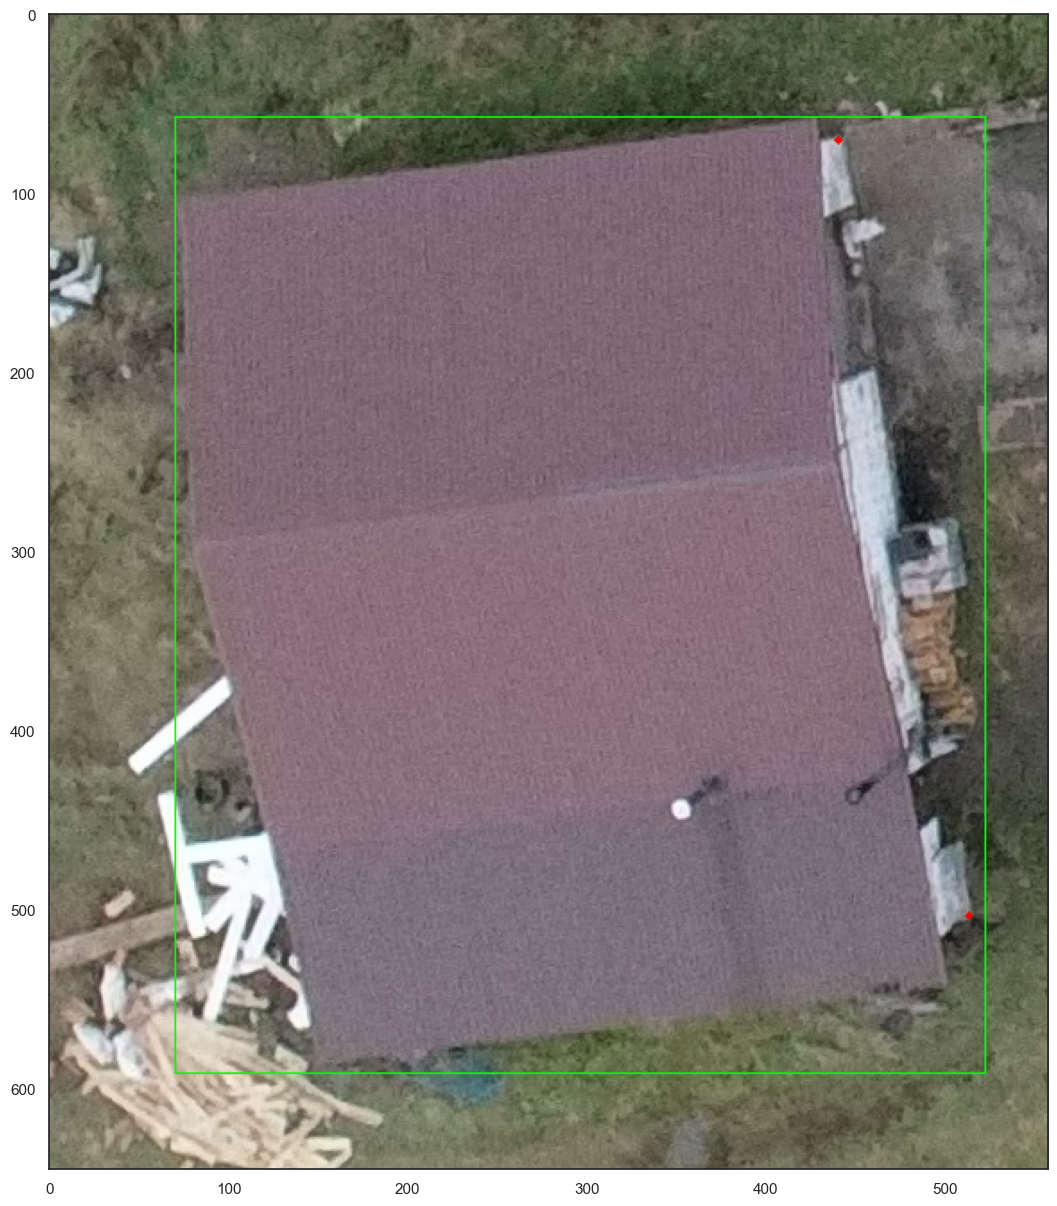

In [11]:
KEYPOINTS_FOLDER = path

dataset = NCornerDataset(KEYPOINTS_FOLDER_TRAIN, transform=None, demo=False, N=9)



data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

iterator = iter(data_loader)
batch = next(iterator)

image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()
#print(bboxes)
#bboxes = (bboxes * [[image.shape[1], image.shape[0], image.shape[1], image.shape[0]]]).astype(np.int32).tolist()
#print(bboxes)
#print(bboxes)

idx = torch.IntTensor.item(batch[1][0]['image_id'])
#print(idx)
print(dataset.annotations_files[idx])

keypoints = []
#print(batch[1][0]['keypoints'].detach().cpu().numpy())
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
#    t = np.array([kp * [image.shape[0], image.shape[1], 1.0] for kp in kps]).astype(np.int32).tolist()
#    keypoints.append(t)
    keypoints.append([kp for kp in kps])


#keypoints = keypoints.numpy().astype(np.int32).tolist()

print(keypoints)
#image_original = (batch[2][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
#bboxes_original = batch[3][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

#keypoints_original = []
#for kps in batch[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
#    keypoints_original.append([kp for kp in kps])
#print(len(dataset))
visualize(image, bboxes, keypoints)

#print(image)
#print(keypoints)

ZON_1_00229_MalMich_auto_crop_0.txt
[[76, 61, 339, 304]]
[[[103, 300, 1], [79, 118, 1], [296, 281, 1], [103, 300, 1], [79, 118, 1], [296, 281, 1], [103, 300, 1], [79, 118, 1], [296, 281, 1]]]


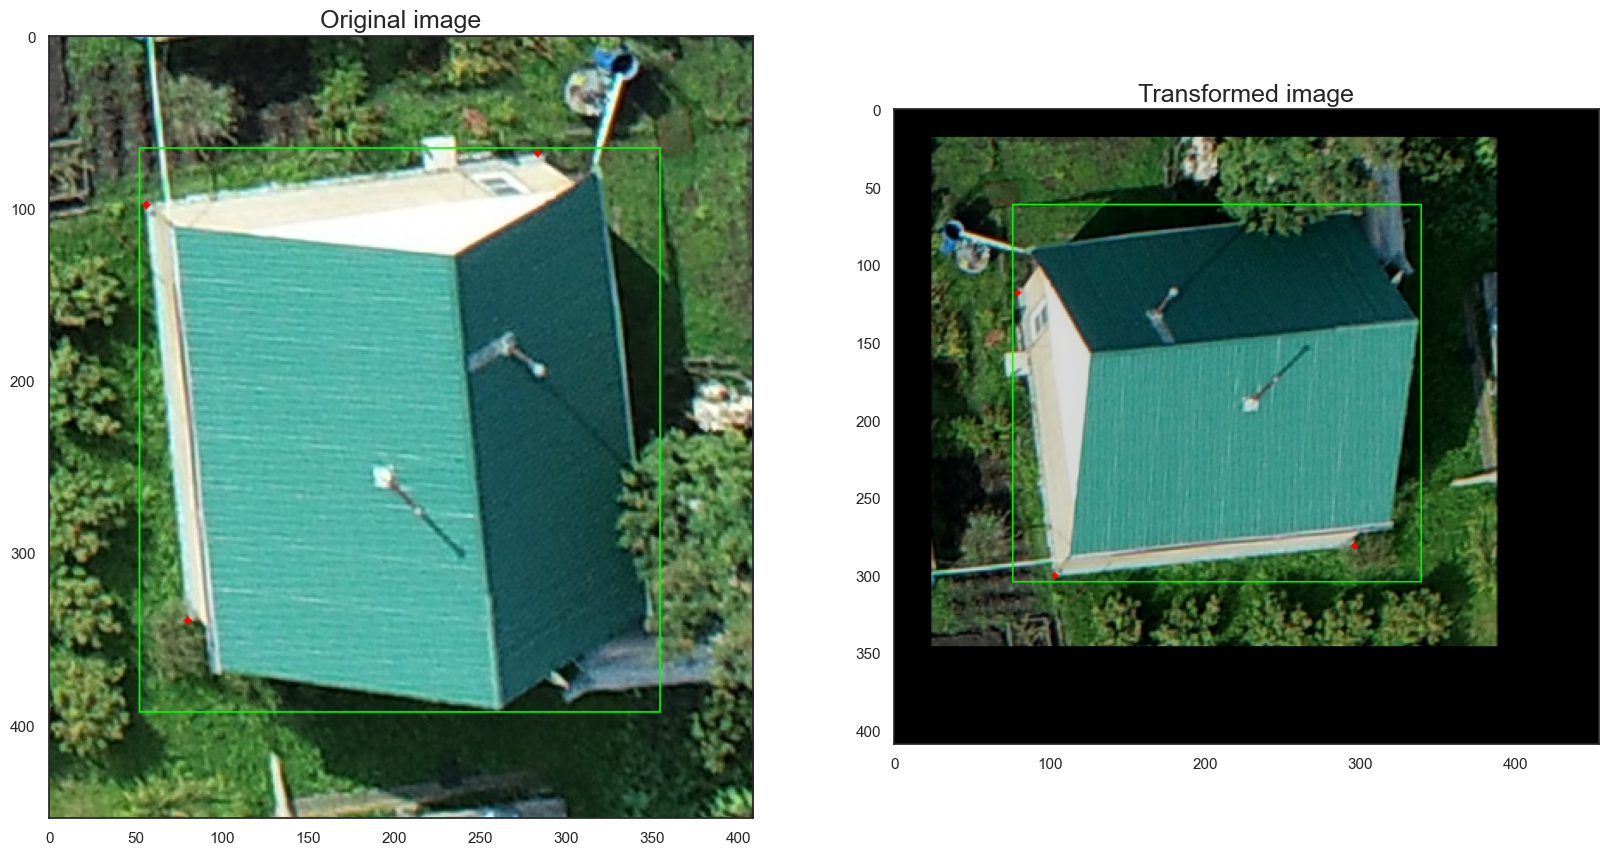

In [12]:
KEYPOINTS_FOLDER_TRAIN = path
dataset = NCornerDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=True, N=9)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

iterator = iter(data_loader)
batch = next(iterator)

image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
#print(image.shape)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()
#bboxes = (bboxes * [[image.shape[0], image.shape[1], image.shape[0], image.shape[1]]]).astype(np.int32).tolist()
#print(bboxes)
idx = torch.IntTensor.item(batch[1][0]['image_id'])
#print(idx)
print(dataset.annotations_files[idx])

keypoints = []
#print(batch[1][0]['keypoints'].detach().cpu().numpy())
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
#    t = np.array([kp * [image.shape[0], image.shape[1], 1.0] for kp in kps]).astype(np.int32).tolist()
#    keypoints.append(t)
    keypoints.append([kp for kp in kps])

image_original = (batch[2][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes_original = batch[3][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()
#bboxes_original = (bboxes_original * [[image_original.shape[1], image_original.shape[0], image_original.shape[1], image_original.shape[0]]]).astype(np.int32).tolist()

keypoints_original = []
for kps in batch[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints_original.append([kp for kp in kps])
#    t = np.array([kp * [image_original.shape[1], image_original.shape[0], 1.0] for kp in kps]).astype(np.int32).tolist()
#    keypoints_original.append(t)
    
#print(keypoints)
#print(len(dataset))
visualize(image, bboxes, keypoints, image_original, bboxes_original, keypoints_original)
print(bboxes)
print(keypoints)

In [13]:
def get_model(num_keypoints, weights_path=None):
   
    
    anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 3.0, 4.0))
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True,
                                                                   pretrained_backbone=True,
                                                                   num_keypoints=num_keypoints,
                                                                   num_classes = 2, # Background is the first class, object is the second class
                                                                   rpn_anchor_generator=anchor_generator)

    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)        
        
    return model


def get_model_V2(num_keypoints, weights_path=None):
    from torchvision.ops import MultiScaleRoIAlign
    from torchvision.models.detection import KeypointRCNN
    
    backbone = torchvision.models.mobilenet_v2(weights='DEFAULT').features
    
    backbone.out_channels = 1280
    
    anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512, 1024),), aspect_ratios=((0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 3.0, 4.0),))
    
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=7, sampling_ratio=2)
    
    
    keypoint_roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'],  output_size=14, sampling_ratio=2)
    
    model = KeypointRCNN(backbone, num_classes=2, num_keypoints=num_keypoints, rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler, keypoint_roi_pool=keypoint_roi_pooler)#, min_size=400, max_size=2000
    
    #for param in model.parameters():
    #    param.requires_grad = False
        
    #for param in model.roi_heads.keypoint_head.parameters():
    #    param.requires_grad = True

    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)        
        
    return model

Epoch: [0]  [  0/395]  eta: 0:40:59  lr: 0.000035  loss: 9.6734 (9.6734)  loss_classifier: 0.7190 (0.7190)  loss_box_reg: 0.0711 (0.0711)  loss_keypoint: 8.0258 (8.0258)  loss_objectness: 0.6840 (0.6840)  loss_rpn_box_reg: 0.1735 (0.1735)  time: 6.2271  data: 0.0469  max mem: 4503
Epoch: [0]  [ 20/395]  eta: 0:04:31  lr: 0.000542  loss: 9.4736 (9.4276)  loss_classifier: 0.5413 (0.5501)  loss_box_reg: 0.0762 (0.0774)  loss_keypoint: 8.0348 (8.0451)  loss_objectness: 0.6909 (0.6906)  loss_rpn_box_reg: 0.0568 (0.0644)  time: 0.4500  data: 0.0624  max mem: 5301
Epoch: [0]  [ 40/395]  eta: 0:03:29  lr: 0.001050  loss: 8.9393 (9.1792)  loss_classifier: 0.1307 (0.3506)  loss_box_reg: 0.0869 (0.0823)  loss_keypoint: 7.9744 (8.0080)  loss_objectness: 0.6534 (0.6725)  loss_rpn_box_reg: 0.0588 (0.0658)  time: 0.4476  data: 0.0654  max mem: 5301
Epoch: [0]  [ 60/395]  eta: 0:03:00  lr: 0.001557  loss: 9.0329 (9.1259)  loss_classifier: 0.2129 (0.3123)  loss_box_reg: 0.1588 (0.1223)  loss_keypoint: 

KeyboardInterrupt: 

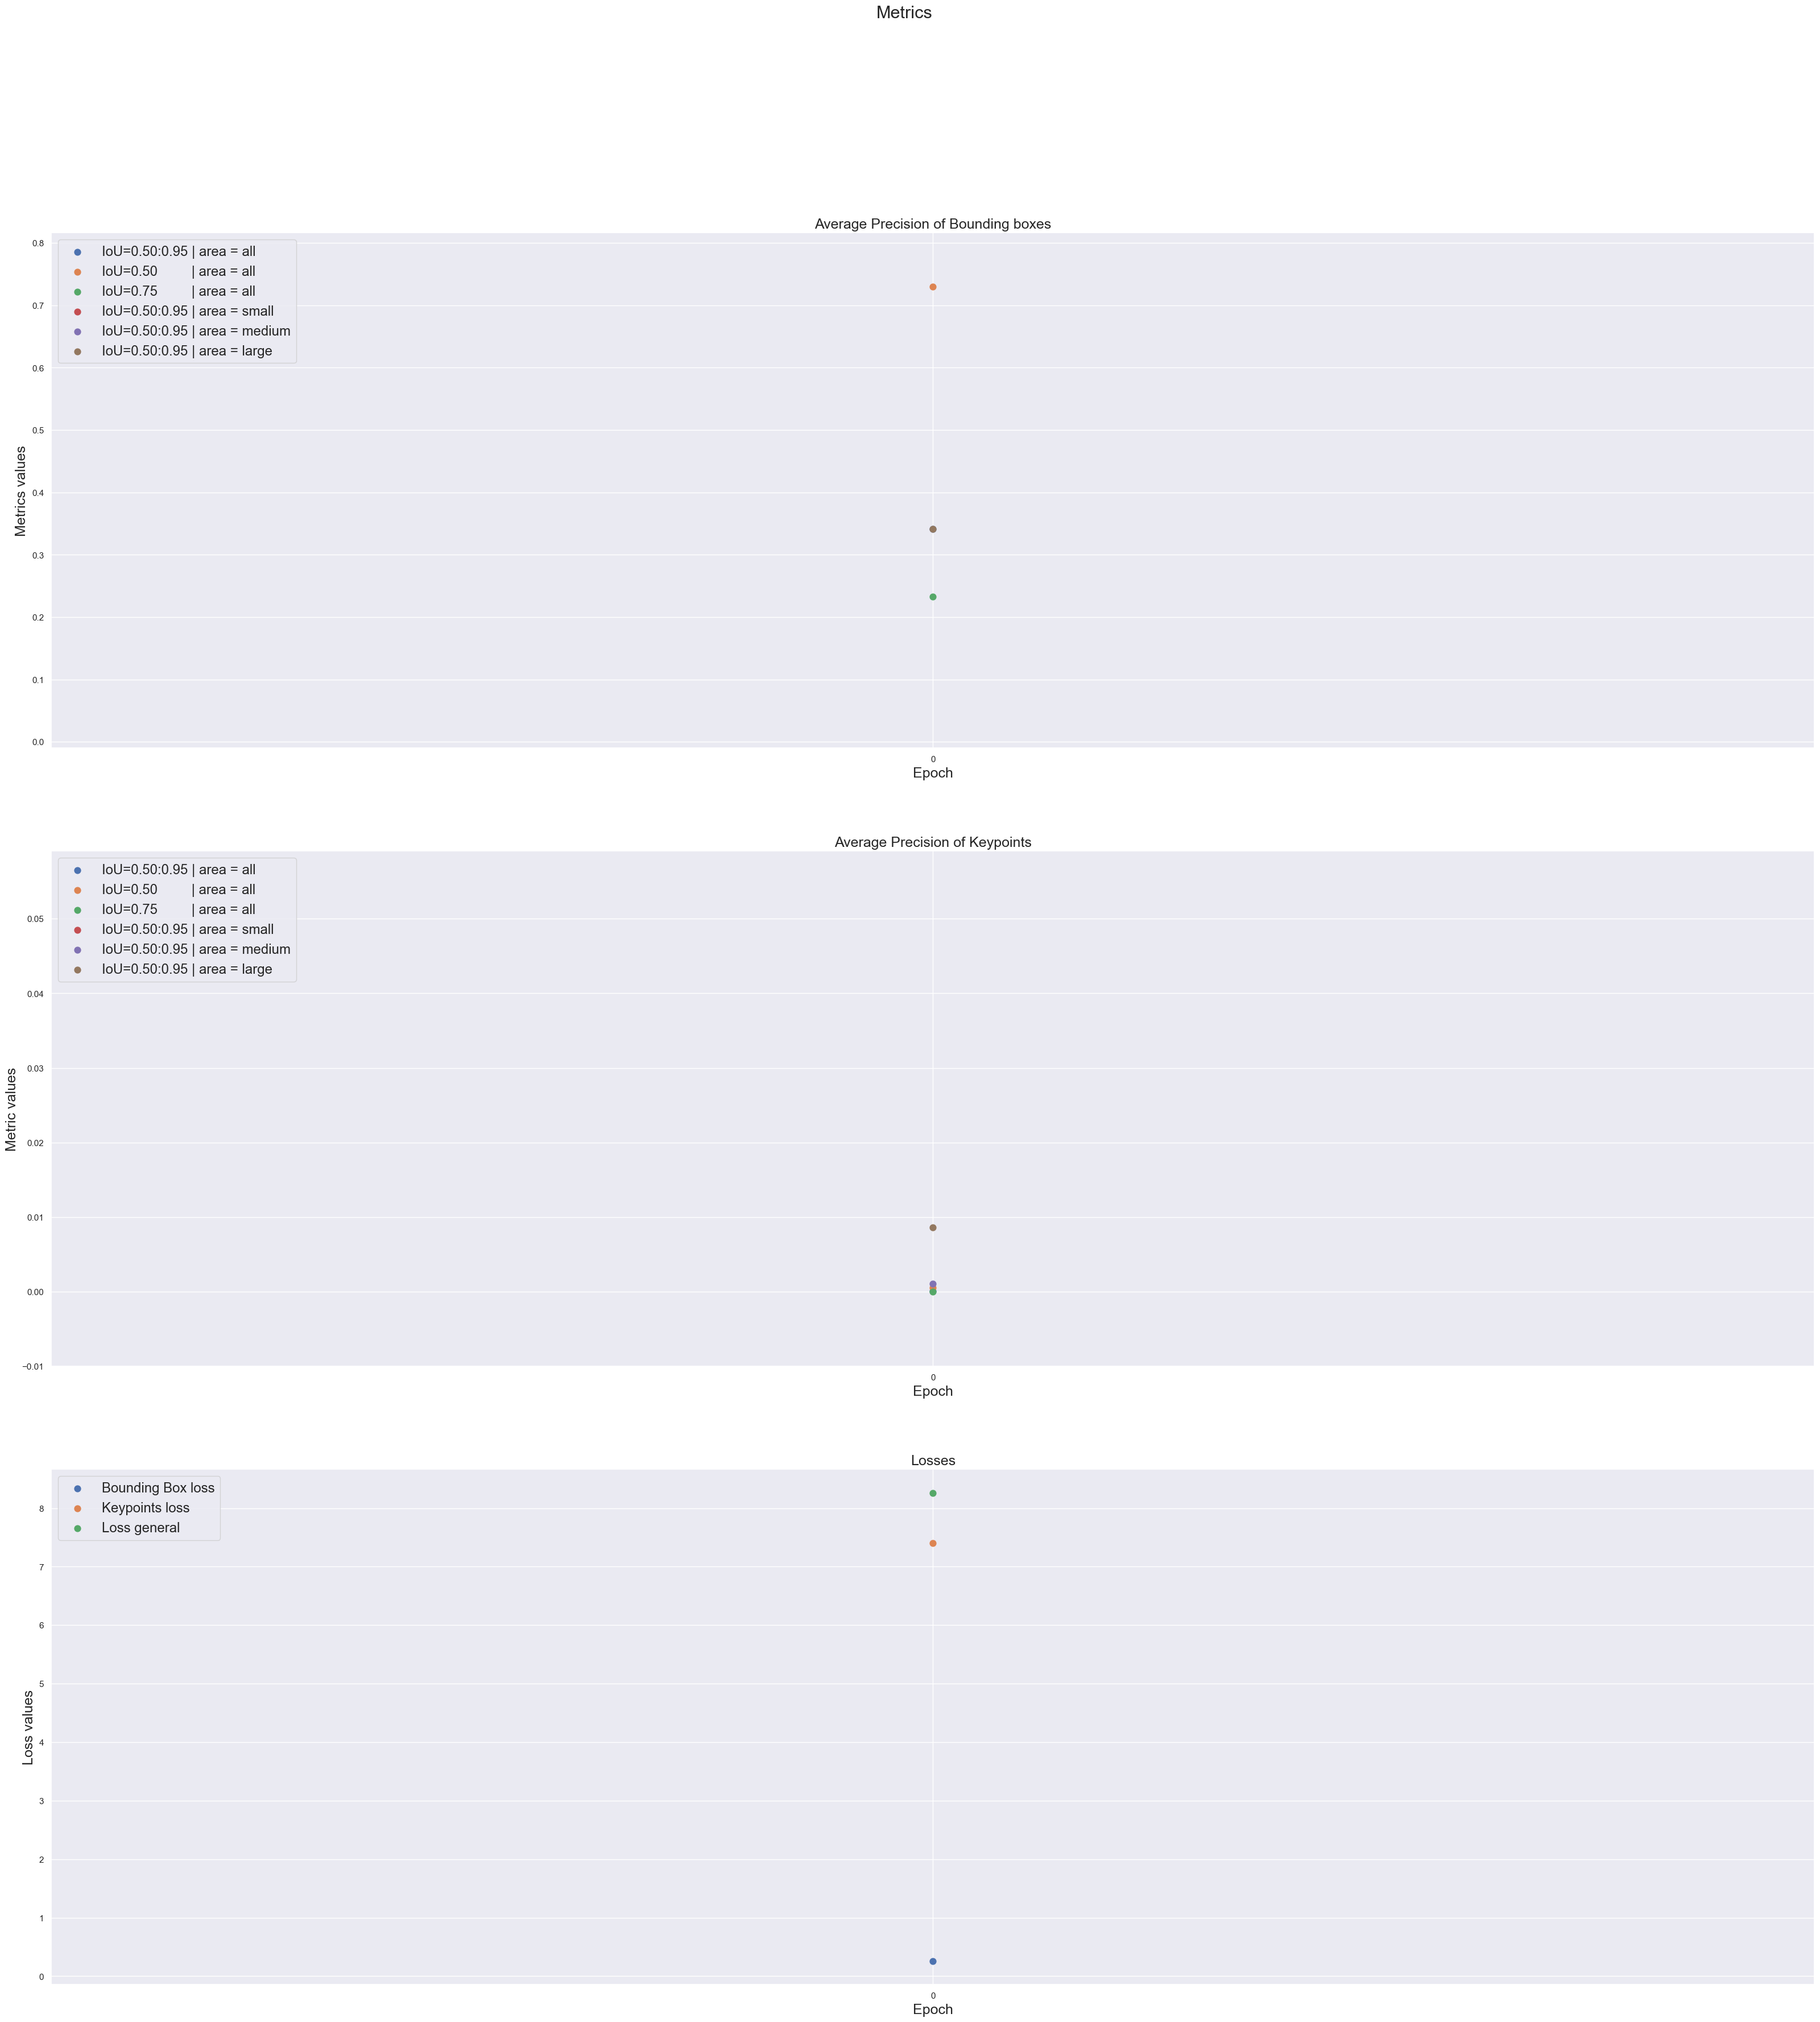

In [14]:
save_path = 'C:/Users/User/Petr/Net_2/save_model'

for num in range(1):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#device = torch.device('cpu')
    
    KEYPOINTS_FOLDER_TRAIN = path
    KEYPOINTS_FOLDER_EVAL = path
    POINTS = 9

    dataset_train = NCornerDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=False, N=POINTS)
    dataset_test = NCornerDataset(KEYPOINTS_FOLDER_EVAL, transform=eval_transform(), demo=False, N=POINTS)

    indices = torch.randperm(len(dataset_train)).tolist()
    thirty_pc = int(len(dataset_train) * 0.15)
    dataset_train = torch.utils.data.Subset(dataset_train, indices[:-thirty_pc])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-thirty_pc:])




    data_loader_train = DataLoader(dataset_train, batch_size=2, shuffle=True, collate_fn=collate_fn)
    data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

    model = get_model_V2(num_keypoints = POINTS)#, weights_path='./save_model/weights_rebuild_model_2.pth'


    model.to(device)
    
    #for p in model.parameters():
    #    p.requires_grad = False
    #for p in model.roi_heads.keypoint_head.parameters():
    #    p.requires_grad = True
    #for p in model.roi_heads.keypoint_predictor.parameters():
    #    p.requires_grad = True

    params = [p for p in model.parameters() if p.requires_grad]
    #params1 = [p for p in model.roi_heads.keypoint_head.parameters() if p.requires_grad]
    
    optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.90)#, weight_decay=0.0001
    
    #optimizer = torch.optim.SGD([{'params': params1},
    #                             {'params': model.roi_heads.keypoint_predictor.parameters(), 'lr': .001},], lr=0.001, momentum=0.90)#, weight_decay=0.0001
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
    num_epochs = 1001

    kps_stats = []
    bbox_stats = []

    loss_bb = []
    loss_kp = []
    loss = []

    for epoch in range(num_epochs):
        logger = train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=20)
        lr_scheduler.step()
        evaluator = evaluate(model, data_loader_test, device)
        
        kps_stats.append(evaluator.coco_eval['keypoints'].stats[:6])
        bbox_stats.append(evaluator.coco_eval['bbox'].stats[:6])
    
        loss_bb.append(logger.meters['loss_box_reg'].global_avg)
        loss_kp.append(logger.meters['loss_keypoint'].global_avg)
        loss.append(logger.meters['loss'].global_avg)
        
        if epoch % 20 == 0:
            torch.save(model.state_dict(), f'{save_path}/9c/weights_9c_re_{epoch}.pth')
            plot_stats(epoch+1, bbox_stats, kps_stats, loss_bb, loss_kp, loss, num=epoch, log_path=save_path)#, num=num
            
    plot_stats(num_epochs, bbox_stats, kps_stats, loss_bb, loss_kp, loss, num=(epoch+1), show=True, log_path=save_path)
#print(type(meters[0]['loss_keypoint']))

# Save model weights after training
#torch.save(model.state_dict(), './save_model/weights_2.pth')
    torch.save(model.state_dict(), f'{save_path}/9c/weights_9c_re_1000.pth')

In [29]:
model.roi_heads.keypoint_head

KeypointRCNNHeads(
  (0): Conv2d(1280, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU(inplace=True)
  (6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
)

In [ ]:
torch.cuda.empty_cache()

In [43]:
# Save model weights after training
torch.save(model.state_dict(), './save_model/weights_2c_re_200.pth')

In [9]:
KEYPOINTS_FOLDER = './'
#dataset_test = ClassDataset(KEYPOINTS_FOLDER, transform=None, demo=False)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_test = get_model_V2(num_keypoints = 2, weights_path='./save_model/weights_2c_2200.pth')
model_test.to(device);

In [ ]:
data_loader_test_1 = DataLoader(dataset_test, batch_size=1, shuffle=True, collate_fn=collate_fn)
iterator = iter(data_loader_test_1)
images, targets = next(iterator)
images = list(image.to(device) for image in images)

with torch.no_grad():
    model.to(device)
    model.eval()
    output = model(images)

#print("Predictions: \n", output)

In [10]:
test_path = 'C:/Users/User/Petr/Net_2/check_model/Rod/images/'

for image in tqdm(os.listdir(test_path)):
    img = cv2.imdecode(np.fromfile(os.path.join(test_path, image), dtype=np.uint8), cv2.IMREAD_UNCHANGED) #cv2.imread(os.path.join(test_path, image))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img_orig = cv2.imdecode(np.fromfile(os.path.join(test_path, image), dtype=np.uint8), cv2.IMREAD_UNCHANGED)
    img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    
    img = F.to_tensor(img)
    type(img)
    img = img.to(device)
    with torch.no_grad():
        model_test.to(device)
        model_test.eval()
        out = model_test([img,])
        out = out[0]
    #img = (img[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
    scores = out['scores'].detach().cpu().numpy()
    kps_scores = out['keypoints_scores'].detach().cpu().numpy()

    high_scores_idxs = np.where(scores > 0.75)[0].tolist() # Indexes of boxes with scores > 0.7
    post_nms_idxs = torchvision.ops.nms(out['boxes'][high_scores_idxs], out['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

# Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
# Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
# Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes
#    print(out['keypoints_scores'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()[0])
    if not len(out['keypoints_scores'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()):
        good_kps_idxs = [[]]
    else:
        good_kps_idxs = np.where(out['keypoints_scores'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()[0] > 5.0) # for i in range(len(post_nms_idxs))
#    print(good_kps_idxs[0])
#    print('KPs: ', out['keypoints_scores'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()[0][good_kps_idxs[0]])
    #kps_scores_filtered = out['keypoints_scores'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()[0][good_kps_idxs[0]]
#print(kps_scores_filtered)

#kps_filtered =  output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()
#out['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()
#print(kps_filtered)

    keypoints = []
    for kps in out['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
        keypoints.append([list(map(int, kp)) for kp in kps[good_kps_idxs[0]]])
    scores = kps_scores[0][good_kps_idxs[0]]
    #kps_scores = out['keypoints_scores'][high_scores_idxs][post_nms_idxs][good_kps_idxs[0]].detach().cpu().numpy()[0]
#kps_idxs = np.where(output[0]['keypoints_scores'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()[0] > 1.2)[0]
#print(kps_idxs)
#print(np.array(keypoints)[0][kps_idxs])
#keypoints = [np.array(keypoints)[0][kps_idxs].tolist()]
    #print(keypoints)
#keypoints = average_close_points(keypoints)
    #print(keypoints)
    #print(kps_scores[0][good_kps_idxs[0]])
    #print(high_scores_idxs, post_nms_idxs, good_kps_idxs[0])
    #break
    bboxes = []
    for bbox in out['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
        bboxes.append(list(map(int, bbox.tolist())))
    bld_scores = out['scores'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy().tolist()
    #print(bld_scores)
    #print(len(bboxes), len(bld_scores))
    #print(type(out[0]['boxes'].detach().cpu().numpy().tolist()))
    visualize(img_orig, bboxes, keypoints, label=image, bld_score=bld_scores, kps_scores=scores)

100%|██████████| 3666/3666 [02:58<00:00, 20.54it/s]


In [17]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_model_V2(num_keypoints = 9, weights_path='./save_model/weights_new_dataset.pth')
model.to(device);
#print(model)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

path = 'C:/Users/User/Desktop/Teobox_Shipunovo_2022-10-16T21.03.14/export_shapes_2/shape_556/'
path_E = './check_model/images'

images = []



for num, label in enumerate(os.listdir(path_E)):
    #print(os.path.join(path_E, label))
    #if num >= 15:
    #    break
    if 'world' in label:
        continue
    img = cv2.imread(os.path.join(path_E, label))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = F.to_tensor(img)
    img = img.to(device)
    images.append((img, label))

images_t = []
for num, label in enumerate(os.listdir(path_E)):
    #if num >= 15:
    #    break
    if 'world' in label:
        continue
    img = cv2.imread(os.path.join(path_E, label))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = F.to_tensor(img)
    #img = img.to(device)
    images_t.append((img, label))
#print(type(images[0][0]))
images_transformed = []
for pair in images_t:
    #img = A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, brightness_by_max=True, always_apply=False, p=1)(image=pair[0])['image']
    #img = A.InvertImg(p=1)(image=img)['image']
    #img = A.Sharpen(alpha=(0.1, 0.9), p=1)(image=img)['image']
    img = test_transform()(image=pair[0])['image']
    img = F.to_tensor(img)
    img = img.to(device)
    images_transformed.append(img)
with torch.no_grad():
    model.to(device)
    model.eval()
    images_to_pred = images_transformed
    output = model(images_to_pred)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_model_V2(num_keypoints = 9, weights_path='./save_model/weights_rebuild_model_3.pth')
model.to(device);
#print(model)

In [ ]:
path = 'C:/Users/User/Desktop/Teobox_Shipunovo_2022-10-16T21.03.14/export_shapes/shape_401/'
path_E = 'C:/Users/User/Petr/Net_2/test_dataset/two_dataset/eval/images'

images = []



for num, label in enumerate(os.listdir(path)):
    if num >= 15:
        break
    if 'world' in label:
        continue
    img = cv2.imread(os.path.join(path, label))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = F.to_tensor(img)
    img = img.to(device)
    images.append((img, label))
#print(images)
with torch.no_grad():
    model.to(device)
    model.eval()
    images_to_pred = [image for (image, label) in images]
    output = model(images_to_pred)

In [ ]:
def get_object_detection_model(num_classes):
    from torch import nn
    import torchvision
    from torchvision.models.detection import FasterRCNN
    from torchvision.models.detection.rpn import AnchorGenerator
    from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
    
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) # lenght of classes WITHOUT background on input
    
#    model.roi_heads.box_predictor.cls_score = nn.Sequential(nn.Linear(1024, 512), nn.Linear(512,256), nn.Linear(256, 128), nn.Linear(128, 2))
    
#    model.roi_heads.box_predictor.bbox_pred = nn.Sequential(nn.Linear(1024, 512), nn.Linear(512,256), nn.Linear(256, 128), nn.Linear(128, 8))

    return model


def load_model(filepath: str):   
    model = get_object_detection_model(num_classes=2)
    model.load_state_dict(torch.load(filepath))
    return model



In [ ]:
for image, out in zip(images, output):
    label = image[1][:-4] + 'big_ds'
    image = (image[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
    scores = out['scores'].detach().cpu().numpy()


    high_scores_idxs = np.where(scores > 0.75)[0].tolist() # Indexes of boxes with scores > 0.7
    post_nms_idxs = torchvision.ops.nms(out['boxes'][high_scores_idxs], out['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

# Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
# Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
# Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes
#    print(out['keypoints_scores'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()[0])
    if not len(out['keypoints_scores'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()):
        good_kps_idxs = [[]]
    else:
        good_kps_idxs = np.where(out['keypoints_scores'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()[0] > 0.0) # for i in range(len(post_nms_idxs))
#    print(good_kps_idxs[0])
#    print('KPs: ', out['keypoints_scores'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()[0][good_kps_idxs[0]])
    #kps_scores_filtered = out['keypoints_scores'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()[0][good_kps_idxs[0]]
#print(kps_scores_filtered)

#kps_filtered =  output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()
#out['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()
#print(kps_filtered)

    keypoints = []
    for kps in out['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
        keypoints.append([list(map(int, kp)) for kp in kps[good_kps_idxs[0]]])
#kps_idxs = np.where(output[0]['keypoints_scores'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()[0] > 1.2)[0]
#print(kps_idxs)
#print(np.array(keypoints)[0][kps_idxs])
#keypoints = [np.array(keypoints)[0][kps_idxs].tolist()]
    print(keypoints)
#keypoints = average_close_points(keypoints)
#print(keypoints)
    
    bboxes = []
    for bbox in out['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
        bboxes.append(list(map(int, bbox.tolist())))
    

    
    visualize(image, bboxes, keypoints)

In [ ]:
import shutil

for file in two_corner_files:
    #shutil.copy(f'./test_dataset/train/images/{file}.jpg', f'./test_dataset/two_dataset/train/images/{file}.jpg')
    #shutil.copy(f'./test_dataset/train/annotations/{file}.txt', f'./test_dataset/two_dataset/train/annotations/{file}.txt')
    
    shutil.copy(f'./test_dataset/eval/images/{file}.jpg', f'./test_dataset/two_dataset/eval/images/{file}.jpg')
    shutil.copy(f'./test_dataset/eval/annotations/{file}.txt', f'./test_dataset/two_dataset/eval/annotations/{file}.txt')
    
for file in three_corners_files:
    #shutil.copy(f'./test_dataset/train/images/{file}.jpg', f'./test_dataset/three_dataset/train/images/{file}.jpg')
    #shutil.copy(f'./test_dataset/train/annotations/{file}.txt', f'./test_dataset/three_dataset/train/annotations/{file}.txt')
    
    shutil.copy(f'./test_dataset/eval/images/{file}.jpg', f'./test_dataset/three_dataset/eval/images/{file}.jpg')
    shutil.copy(f'./test_dataset/eval/annotations/{file}.txt', f'./test_dataset/three_dataset/eval/annotations/{file}.txt')

In [ ]:
import shutil

for file in os.listdir('./annotations/'):
    if file[:-4] not in extra_annotations:
        shutil.copy(f'./annotations/{file}', f'./annotations_clear/{file}')

In [ ]:
#import numpy as np

def average_close_points(point_coords): 
    #point_coords = np.array([point[:-1] for point in point_coords[0]])
    point_coords = np.array(point_coords[0])
    maping = np.abs(point_coords[:, None, None] - point_coords[None, :, None]) <= 3
    print(maping)
    maping = maping.reshape(maping.shape[0], maping.shape[1], 3)
    print(maping)
    res = []
    for point in maping:
        res.append(np.average(point_coords, axis=0, weights=point))
    #point_coords = np.average(point_coords, axis=0, weights=maping)
    
    return [np.unique(res, axis=0).astype(int)]

In [ ]:
average_close_points(keypoints)

In [ ]:
from torchview import draw_graph

model_v = get_model(num_keypoints=4)

model_graph = draw_graph(model_v, input_size=(1, 3, 128, 128))
model_graph.visual_graph

In [17]:
from torch import nn
from torch.nn import functional as Fnn

class MyModel(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16,kernel_size=(2,2),stride=1,padding='valid')
        self.conv1_1 = nn.Conv2d(in_channels=16, out_channels=32,kernel_size=(2,2),stride=1,padding='same')
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2))
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(2,2),stride=1,padding='valid')
        self.conv2_2 = nn.Conv2d(in_channels=64,out_channels=32,kernel_size=(2,2),stride=1,padding='same')
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2))
        self.dropout1 = nn.Dropout(0.5)
        self.linear1 = nn.Linear(in_features=32*149*149,out_features=500)
        self.linear2 = nn.Linear(in_features=500,out_features=250)
        self.dropout2 = nn.Dropout(0.5)
        self.linear3 = nn.Linear(in_features=250,out_features=18)


    def forward(self,x):
        #x = cv2.resize(x, (600, 600))
        x = Fnn.relu(self.conv1(x))
        x = Fnn.relu(self.conv1_1(x))
        x = self.maxpool1(x)
        x = Fnn.relu(self.conv2(x))
        x = Fnn.relu(self.conv2_2(x))
        x = self.maxpool2(x)
        #print(x.shape)
        x = x.view(-1,32*149*149) 
        x = self.dropout1(x)
        x = Fnn.relu(self.linear1(x))
        x = Fnn.relu(self.linear2(x))
        x = self.dropout2(x)
        x = self.linear3(x)
        return x


In [26]:
model_self = MyModel()

criterion = nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.Adamax(model.parameters(), lr=0.001)
#device = torch.device('cuda')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_self.to(device)
# Training loop
num_epochs = 5

KEYPOINTS_FOLDER_TRAIN = './NEW_DATASET'
KEYPOINTS_FOLDER_EVAL = './NEW_DATASET'

dataset_train = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=False)
dataset_test = ClassDataset(KEYPOINTS_FOLDER_EVAL, transform=None, demo=False)

data_loader_train = DataLoader(dataset_train, batch_size=1, shuffle=True, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(data_loader_train):
         # [[[x, y, v], [x, y, v], [0 , 0, 0], [0 , 0, 0], [0 , 0, 0], [0 , 0, 0], [0 , 0, 0], [0 , 0, 0], [0 , 0, 0], [0 , 0, 0]]]
        points = [point for point in labels[0]['keypoints'][0]]
        kps = []
        for point in points:
            x, y, v = point
            kps.append([(x-600)/600, (y-600)/600])
        #kps = [(x, y) for point in points for x, y, v in point]
        #kps.reshape(1, 8)
        #print(kps)
        #print(images[0].numpy())
        images = cv2.resize(images[0].numpy().transpose(1,2,0), (600, 600))
        #print(images)
        images = F.to_tensor(images).cuda()
        labels = torch.as_tensor(kps).cuda()
        # Clear the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model_self(images).to(device)
        #print(outputs)
        labels = labels.view(-1, 18)
        #print(labels)
        loss = torch.sqrt(criterion(outputs, labels))
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        # Print Epoch, Step and Loss value.
        if (i+1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(data_loader_train), loss.item()))

Epoch [1/5], Step [10/499], Loss: 0.7791
Epoch [1/5], Step [20/499], Loss: 0.7196
Epoch [1/5], Step [30/499], Loss: 0.8024
Epoch [1/5], Step [40/499], Loss: 0.3071
Epoch [1/5], Step [50/499], Loss: 0.7482
Epoch [1/5], Step [60/499], Loss: 0.7395
Epoch [1/5], Step [70/499], Loss: 0.4276
Epoch [1/5], Step [80/499], Loss: 0.4259
Epoch [1/5], Step [90/499], Loss: 0.8067
Epoch [1/5], Step [100/499], Loss: 0.2550
Epoch [1/5], Step [110/499], Loss: 0.4253
Epoch [1/5], Step [120/499], Loss: 0.6937
Epoch [1/5], Step [130/499], Loss: 0.5298
Epoch [1/5], Step [140/499], Loss: 0.8191
Epoch [1/5], Step [150/499], Loss: 0.8378
Epoch [1/5], Step [160/499], Loss: 0.8249
Epoch [1/5], Step [170/499], Loss: 0.6303
Epoch [1/5], Step [180/499], Loss: 0.6929
Epoch [1/5], Step [190/499], Loss: 0.7637
Epoch [1/5], Step [200/499], Loss: 0.8015
Epoch [1/5], Step [210/499], Loss: 0.7777
Epoch [1/5], Step [220/499], Loss: 0.7560
Epoch [1/5], Step [230/499], Loss: 0.4763
Epoch [1/5], Step [240/499], Loss: 0.6496
E

In [ ]:
import re
def has_cyrillic(text):
    return bool(re.search('[а-яА-Я]', text))

path = 'C:/Users/User/Petr/Net_2/test.jpg'

has_cyrillic(path)

In [ ]:
image = cv2.imdecode(np.fromfile(path, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,15))
plt.imshow(image)